### ISP Lab06
### Nguyễn Quốc Bảo - 18110053
### Faculty of Mathematics and Computer Science,
### University of Science, HCMC

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries
from scipy import ndimage as ndi
import pandas as pd
import json
import os
import timeit
import random

In [2]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt
    import matplotlib.gridspec as gridspec
    
    gs = gridspec.GridSpec(nRows, nCols)
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        
        plt.subplot(nRows, nCols,i+1)
        
        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
            plt.title("Image " + str(i))
            plt.axis('off')
    plt.show()

In [3]:
def morphology(Mask, Size):
    from skimage.morphology import erosion, dilation, opening, closing, white_tophat
    from skimage.morphology import disk
    selem = disk(abs(Size))
    if(Size > 0):
        result = dilation(Mask, selem)
    else:
        result = erosion(Mask, selem)
    return result

In [4]:
import os
import pandas as pd
def get_subfiles(dir):
    "Get a list of immediate subfiles"
    return next(os.walk(dir))[2]

In [5]:
def SegmentColorImageByMask(IM, Mask):
    Mask = Mask.astype(np.uint8)
    result = cv2.bitwise_and(IM, IM, mask = Mask)
    return result
def SegmentationByOtsu(image, mask):
    image_process = image.copy()
    image_mask = mask.copy()
    image_process[image_mask == 0] = 0
    ListPixel = image_process.ravel()
    ListPixel = ListPixel[ListPixel > 0]
    from skimage.filters import threshold_otsu
    otsu_thresh = threshold_otsu(ListPixel)
    return otsu_thresh
def SegmentByKmeans(image_orig, nClusters = 3):

    img = image_orig.copy()
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
    K = nClusters
    ret,labellist,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[labellist.flatten()]
    res2 = res.reshape((img.shape))
    label2 = labellist.reshape((img.shape[:2]))
    
    image_index = label2
    image_kmeans = res2
    # Sort to make sure the index is stable
    AreaList = []
    for idx in range(image_index.max() + 1):
        mask = image_index == idx
        AreaList.append(mask.sum().sum())
        
    sort_index = np.argsort(AreaList)[::-1]
    index = 0
    image_index1 = image_index * 0
    for idx in sort_index:
        image_index1[image_index == idx] = index
        index = index + 1
    image_index = image_index1.copy()
    return image_index, image_kmeans

In [6]:
def ResizeImage(IM, DesiredWidth, DesiredHeight):
    from skimage.transform import rescale, resize
    OrigWidth = float(IM.shape[1])
    OrigHeight = float(IM.shape[0])
    Width = DesiredWidth
    Height = DesiredHeight
    if((Width == 0) & (Height == 0)):
        return IM
    if(Width == 0):
        Width = int((OrigWidth * Height)/OrigHeight)
    if(Height == 0):
        Height = int((OrigHeight * Width)/OrigWidth)
    dim = (Width, Height)
    # print(dim)
    resizedIM = cv2.resize(IM, dim, interpolation = cv2.INTER_NEAREST)
    # imshows([IM, resizedIM], ["Image", "resizedIM"],1,2)
    return resizedIM

In [7]:
def LabelObjectByMask(image_input, image_mask, type = "BBox", color = (0,255,0), thick = 2):

    image_input = image_orig.copy()
    image_output = image_input.copy()
    label_img = label(image_mask)
    regions = regionprops(label_img)
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        left_top = (minc, minr)
        right_bottom = (maxc, maxr)
        at_row, at_col = props.centroid
        if(type == "Center"):
            cv2.drawMarker(image_output, (int(at_col), int(at_row)),color, markerType=cv2.MARKER_STAR,\
                       markerSize=15, thickness= 1, line_type=cv2.LINE_AA)
        if(type == "BBox"):
            cv2.rectangle(image_output,left_top, right_bottom, color ,thick)
    
    if(type == "Boundary"):
        color = [(number / 255) for number in color]
        image_mask = morphology(image_mask, 1)
        image_output = mark_boundaries(image_output, image_mask, color = color, mode='thick')
    
    if(type == "Fill"):
        image_output[image_mask > 0] = color
    return image_output

def SelectMaskByThreshArea(Mask, minArea = 300, maxArea = 100000):

    import pandas as pd
    from skimage.measure import label, regionprops
    mask = Mask.copy()
    mask_output = mask * 0
    bboxList = []
    
    label_img = label(mask)
    regions = regionprops(label_img)
    for props in regions:
        area = props.area
        label = props.label
        if((area > minArea) and (area < maxArea)):
            mask_output = mask_output + (label_img == label).astype(int)
    return mask_output



In [8]:
DataPath = "Lab06 - Image/"
path = DataPath
all_names = get_subfiles(path)
print("Number of Images:", len(all_names))
IMG = []
for i in range(len(all_names)):
    tmp = cv2.imread(path + all_names[i])
    IMG.append(tmp)
SegDataIMG = IMG.copy()
SegDataName = all_names

Number of Images: 60


### Vết Defect A

Selected Image :  
Index  4 
Name  DefectA 03.bmp


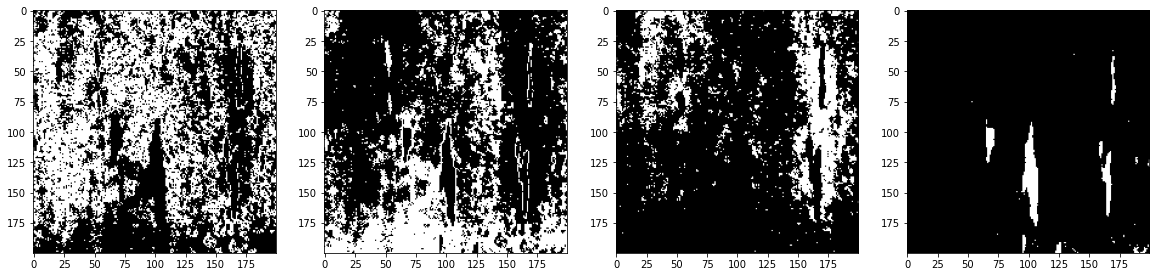

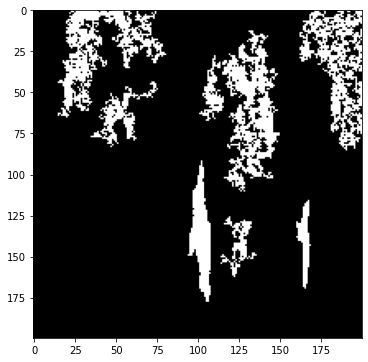

In [9]:
FileName = 'DefectA 03.bmp'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)


h = image_hsv[:,:,0]
s = image_hsv[:,:,1]
v = image_hsv[:,:,2]
y = image_ycbcr[:,:,0]
cb = image_ycbcr[:,:,1]
cr = image_ycbcr[:,:,2]


image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 4)

mask_list = []
mask_abnormal = image_gray * 0
for idx in range(image_index.max() + 1):
    imask = image_index == idx
    mask_small = SelectMaskByThreshArea(imask, minArea = 200, maxArea = 2000)
#     mask_small=SegmentColorImageByMask(image_index, imask)
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

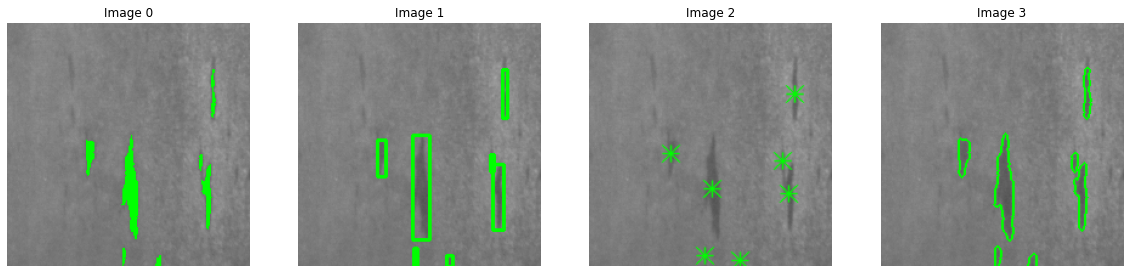

In [10]:
imask = image_index == 3
label_img = label(imask)
# label_img = label(mask_abnormal)
regions = regionprops(label_img, intensity_image = image_hsv[:,:,0])

mask_condition1 = mask_abnormal * 0

for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel
    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity
    condition1 = (area > 20) and (area < 2000)
#     condition2 = (area > 20) and (area < 2000)

    if(condition1):
        mask_condition1 = mask_condition1 + (imask).astype(int)

image_output1 = LabelObjectByMask(image_orig, mask_condition1, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition1, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition1, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition1, type = "Boundary", color = (0,255,0), thick =
2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)


### Vết Defect B

Selected Image :  
Index  10 
Name  DefectB 04.bmp


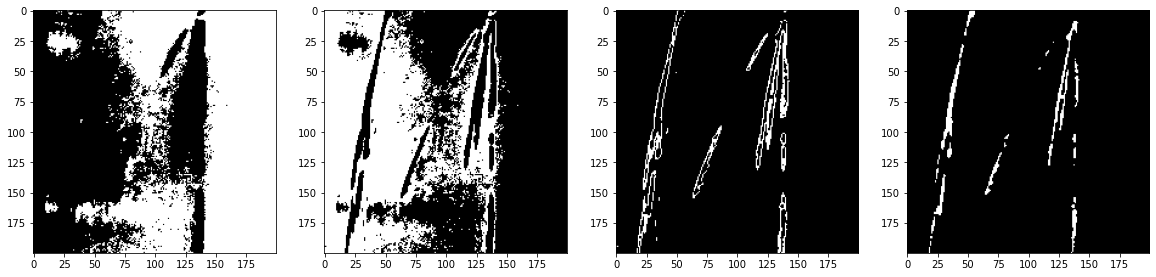

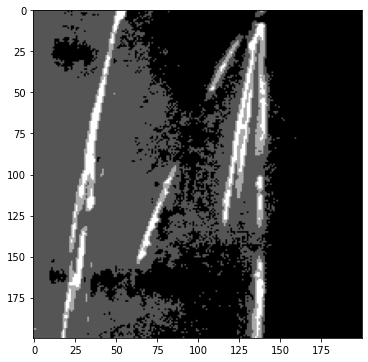

In [11]:
FileName = 'DefectB 04.bmp'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)


h = image_hsv[:,:,0]
s = image_hsv[:,:,1]
v = image_hsv[:,:,2]
y = image_ycbcr[:,:,0]
cb = image_ycbcr[:,:,1]
cr = image_ycbcr[:,:,2]


image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 4)

mask_list = []
mask_abnormal = image_gray * 0
for idx in range(image_index.max() + 1):
    imask = image_index == idx
#     mask_small = SelectMaskByThreshArea(imask, minArea = 200, maxArea = 2000)
    mask_small=SegmentColorImageByMask(image_index, imask)
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

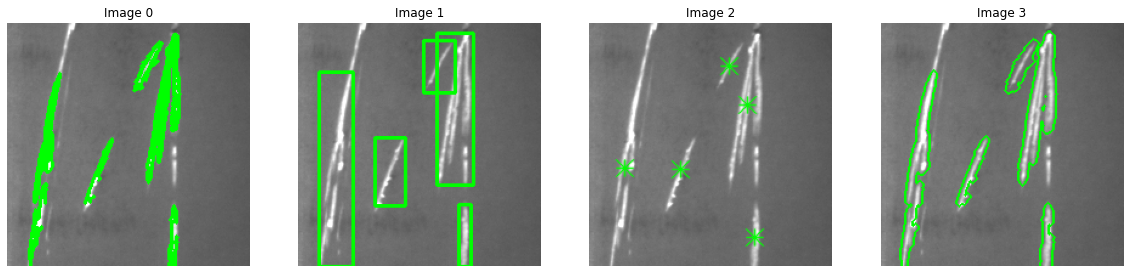

In [12]:


# imask = image_index == 3
# label_img = label(imask)
label_img = label(mask_abnormal)
regions = regionprops(label_img, intensity_image = image_hsv[:,:,0])

mask_condition1 = mask_abnormal * 0

for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel
    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity
    condition1 = (area > 1000) and (area < 2000)
    condition2 = (area > 100) and (area < 800)

    if(condition1 or condition2):
        mask_condition1 = mask_condition1 + (imask).astype(int)
mask_condition1 = morphology(mask_condition1,1)
image_output1 = LabelObjectByMask(image_orig, mask_condition1, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition1, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition1, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition1, type = "Boundary", color = (0,255,0), thick =
2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

### Biển số xe

Selected Image :  
Index  14 
Name  DrivingPlate 03.jpg


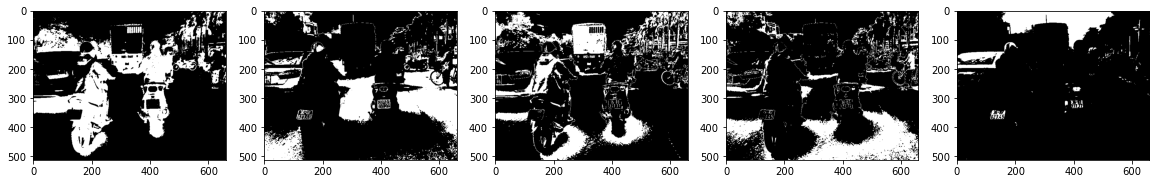

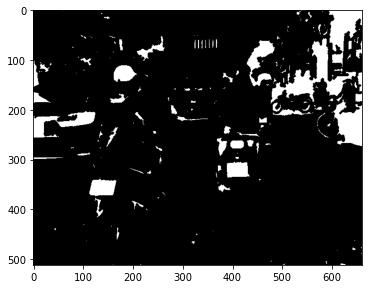

In [13]:
FileName = 'DrivingPlate 03.jpg'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)


h = image_hsv[:,:,0]
s = image_hsv[:,:,1]
v = image_hsv[:,:,2]
y = image_ycbcr[:,:,0]
cb = image_ycbcr[:,:,1]
cr = image_ycbcr[:,:,2]


image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 5)

mask_list = []
mask_abnormal = image_gray * 0
for idx in range(image_index.max() + 1):
    imask = image_index == idx
    mask_small = SelectMaskByThreshArea(imask, minArea = 0, maxArea = 1000)
#     mask_small=SegmentColorImageByMask(image_index, imask)
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small
    
mask_abnormal = morphology(mask_abnormal, -2)
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

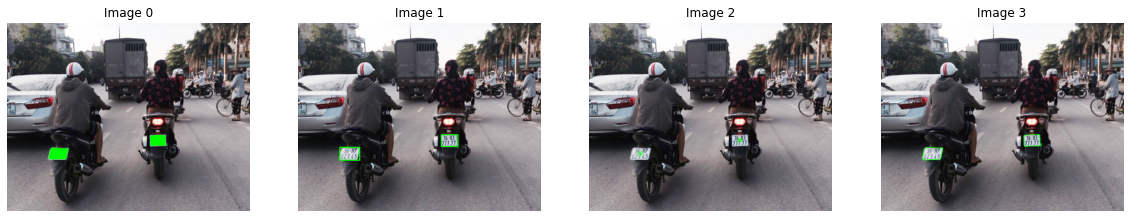

In [14]:

# imask = image_index == 3
# label_img = label(imask)
label_img = label(mask_abnormal)
regions = regionprops(label_img, intensity_image= image_gray)

mask_condition1 = mask_abnormal * 0

for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel

    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity

    minr, minc, maxr, maxc = props.bbox
    width = maxc - minc
    height = maxr - minr
    ratewh = width/height

    condition1 = (imean > 150) and (imin < 70) and (ratewh > 1.4) and (ratewh < 1.8)
    condition2 = props.major_axis_length > 20

    if(condition1 and condition2):
        mask_condition1 = mask_condition1 + (imask).astype(int)

image_output1 = LabelObjectByMask(image_orig, mask_condition1, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition1, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition1, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition1, type = "Boundary", color = (0,255,0), thick =2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

### Vết xuất huyết và xuất tiết

Selected Image :  
Index  20 
Name  Eye 05.jpg


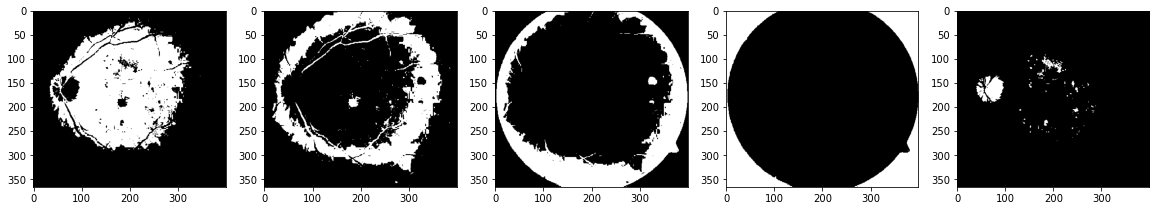

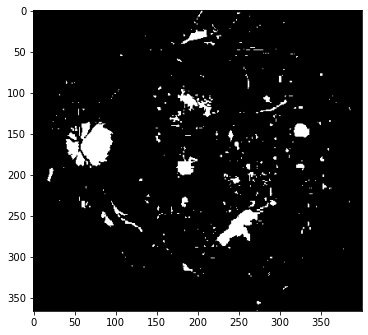

In [15]:
FileName = 'Eye 05.jpg'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)

h = image_hsv[:,:,0]
s = image_hsv[:,:,1]
v = image_hsv[:,:,2]
y = image_ycbcr[:,:,0]
cb = image_ycbcr[:,:,1]
cr = image_ycbcr[:,:,2]

image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 5)
# ShowImage([image_orig, image_index, image_kmeans], 1, 3)
mask_list = []
mask_abnormal = image_gray * 0

for idx in range(image_index.max() + 1):
    imask = image_index == idx
    mask_small = SelectMaskByThreshArea(imask, minArea = 0, maxArea = 2000)
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

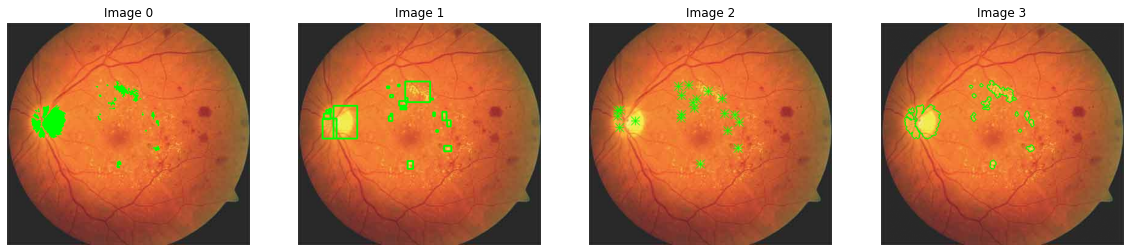

In [16]:
label_img = label(mask_abnormal)
regions = regionprops(label_img, intensity_image=cr)
mask_condition1 = mask_abnormal * 0
mask_condition2 = mask_abnormal * 0
for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel

    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity

    condition1 = (area > 5) and (area < 5000) and (imean < 70)
    condition2 = (area > 5) and (area < 300) and (imean > 80)

    if(condition1):
        mask_condition1 = mask_condition1 + (imask).astype(int)

    if(condition2):
        mask_condition2 = mask_condition2 + (imask).astype(int)
image_output1 = LabelObjectByMask(image_orig, mask_condition1, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition1, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition1, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition1, type = "Boundary", color = (0,255,0), thick =
2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)


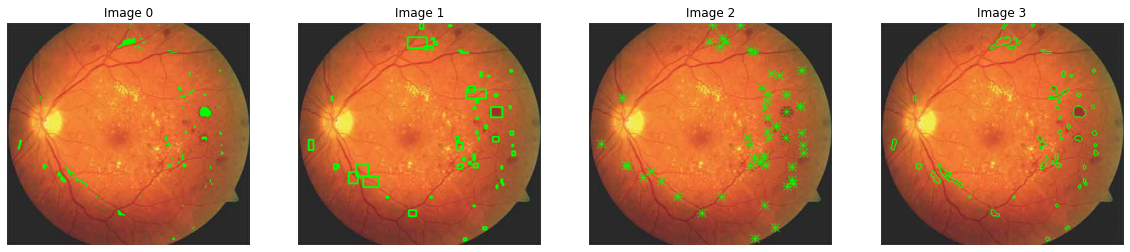

In [17]:
image_output1 = LabelObjectByMask(image_orig, mask_condition2, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition2, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition2, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition2, type = "Boundary", color = (0,255,0), thick = 2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

### Khuôn mặt người

Selected Image :  
Index  24 
Name  Face 04.jpg


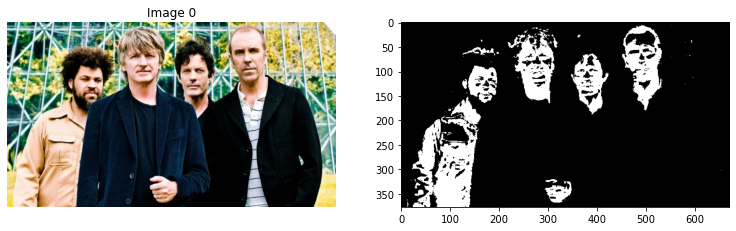

In [18]:
FileName = 'Face 04.jpg'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)

lower = np.array([0, 39, 80], dtype = "uint8")
upper = np.array([15, 240, 255], dtype = "uint8")
skinMask = cv2.inRange(image_hsv, lower, upper)
ShowImage([image_orig,skinMask],1,3)

6685 0.46551724137931033 0.47431531148006245
6720 0.6462585034013606 0.48120300751879697
4333 0.608 0.45610526315789474
2804 0.7894736842105263 0.6149122807017544


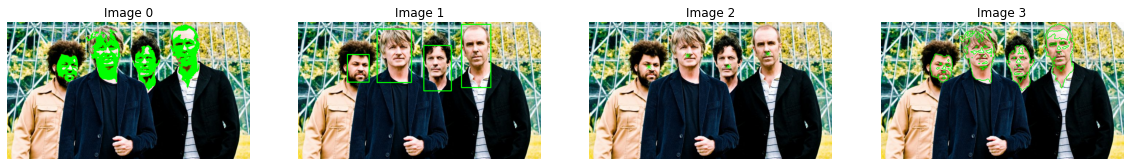

In [19]:
label_img = label(skinMask)
regions = regionprops(label_img, intensity_image= image_ycbcr[:,:,1])
mask_condition = skinMask * 0
for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel

    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity
    app_std = (imax - imin)/4

    minr, minc, maxr, maxc = props.bbox
    width = maxc - minc
    height = maxr - minr
    ratewh = width/height
    rateArea = area/ (width * height)

    condition = (area > 2000) and (area < 9000) and (ratewh < 1.5) and (rateArea > 0.1)
    if(condition):
        mask_condition = mask_condition + (imask).astype(int)
        print(area, ratewh, rateArea)
# mask_condition = morphology(mask_condition,2)
image_output1 = LabelObjectByMask(image_orig, mask_condition, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition, type = "Boundary", color = (0,255,0), thick = 2
)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

### Lửa

Selected Image :  
Index  28 
Name  Fire 03.jpg


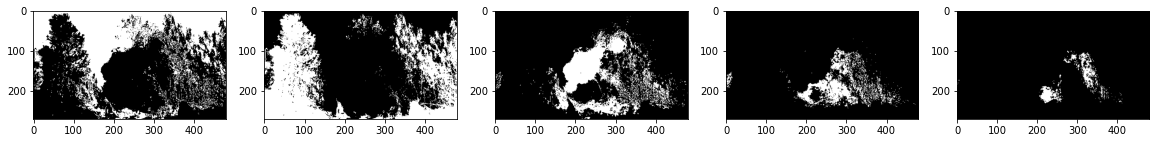

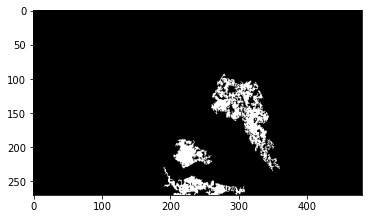

In [20]:
FileName = 'Fire 03.jpg'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)



image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 5)

mask_list = []
mask_abnormal = image_gray * 0
for idx in range(image_index.max() + 1):
    imask = image_index == idx
    mask_small = SelectMaskByThreshArea(imask, minArea = 900, maxArea = 3000)
#     mask_small=SegmentColorImageByMask(image_index, imask)
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small

ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

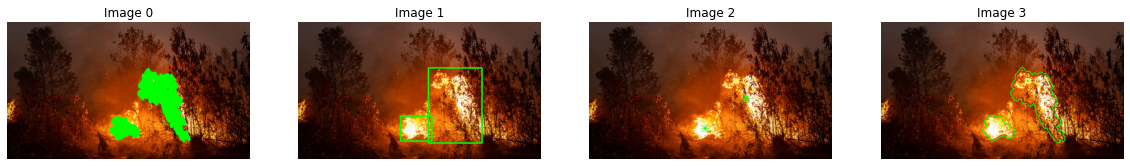

In [21]:


label_img = label(mask_abnormal)
regions = regionprops(label_img, intensity_image= image_gray)

mask_condition1 = mask_abnormal * 0

for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel

    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity


    condition1 = (((area >900) and (area <1200)) or ((area >1400) and (area < 5000))) and (imean > 150)

    if(condition1):
        mask_condition1 = mask_condition1 + (imask).astype(int)
mask_condition1 = morphology(mask_condition1,3)
image_output1 = LabelObjectByMask(image_orig, mask_condition1, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition1, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition1, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition1, type = "Boundary", color = (0,255,0), thick =2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

### Bông hoa

Selected Image :  
Index  33 
Name  Flower 03.jpg


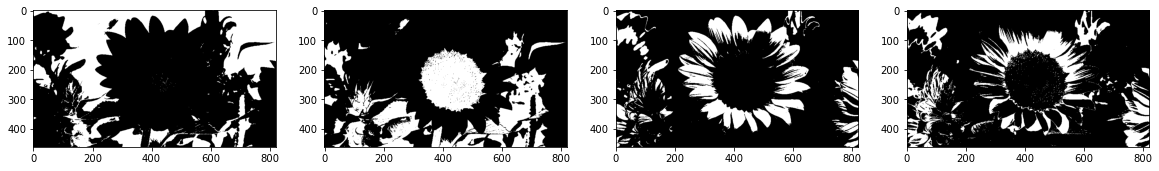

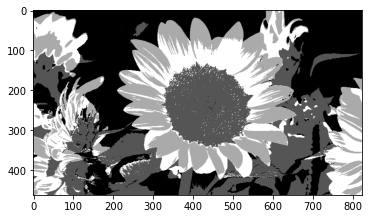

In [22]:
FileName = 'Flower 03.jpg'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)

image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 4)

mask_list = []
mask_abnormal = image_gray * 0
for idx in range(image_index.max() + 1):
    imask = image_index == idx
#     mask_small = SelectMaskByThreshArea(imask, minArea = 900, maxArea = 3000)
    mask_small=SegmentColorImageByMask(image_index, imask)
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

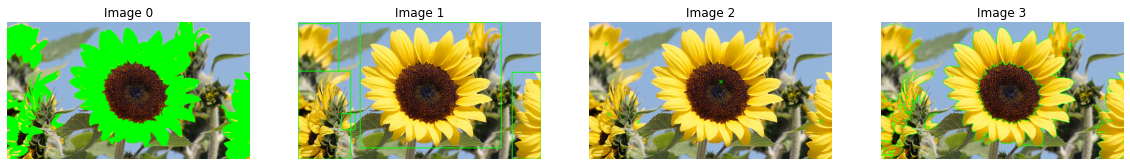

In [23]:


label_img = label(mask_abnormal)
regions = regionprops(label_img, intensity_image= image_gray)

mask_condition1 = mask_abnormal * 0

for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel

    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity


    condition1 = (area > 200 and area < 23000)  and (imean > 150) 

    if(condition1):
        mask_condition1 = mask_condition1 + (imask).astype(int)

image_output1 = LabelObjectByMask(image_orig, mask_condition1, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition1, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition1, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition1, type = "Boundary", color = (0,255,0), thick =2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

### Trái bóng

Selected Image :  
Index  1 
Name  Football 02.jpg


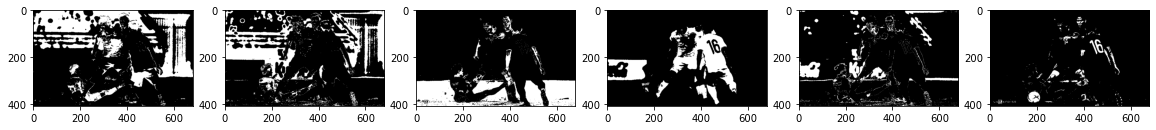

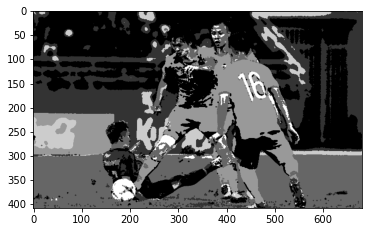

In [24]:
FileName = 'Football 02.jpg'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)

image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 6)

mask_list = []
mask_abnormal = image_gray * 0
for idx in range(image_index.max() + 1):
    imask = image_index == idx
    mask_small=SegmentColorImageByMask(image_index, imask)
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small
mask_abnormal = morphology(mask_abnormal, -1)
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

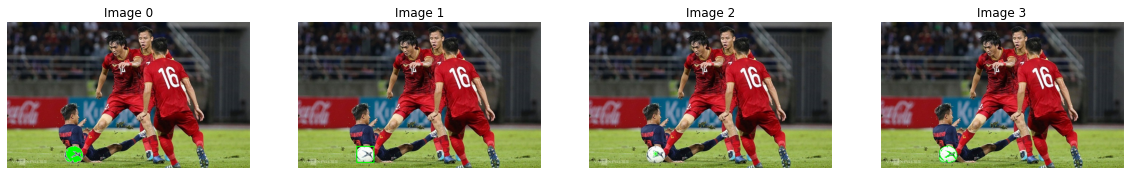

In [25]:
label_img = label(mask_abnormal)
regions = regionprops(label_img, intensity_image= image_gray)

mask_condition1 = mask_abnormal * 0

for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel

    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity


    condition1 = (((area >700 )) ) and (imean > 200)
    
    if(condition1):
        mask_condition1 = mask_condition1 + (imask).astype(int)

image_output1 = LabelObjectByMask(image_orig, mask_condition1, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition1, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition1, type = "Center", color = (0,255,0), thick = 3)
image_output4 = LabelObjectByMask(image_orig, mask_condition1, type = "Boundary", color = (0,255,0), thick =2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

### Bàn Tay

Selected Image :  
Index  44 
Name  Hand Gesture 05.jpg


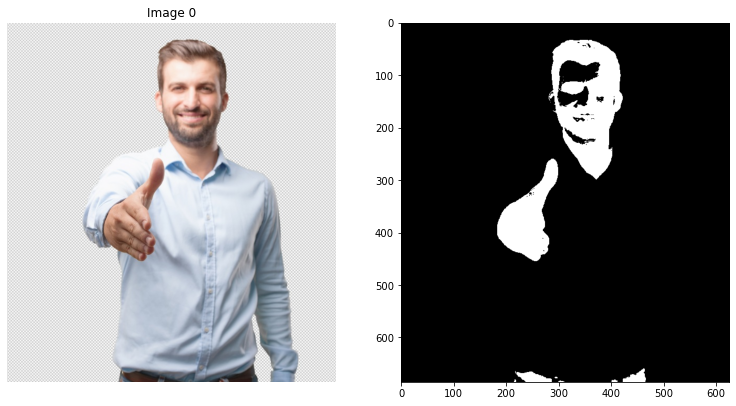

In [26]:
FileName = 'Hand Gesture 05.jpg'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)

lower = np.array([0, 40, 10], dtype = "uint8")
upper = np.array([23, 218, 245], dtype = "uint8")
skinMask = cv2.inRange(image_hsv, lower, upper)
ShowImage([image_orig,skinMask],1,3)

/home/qbao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
  


10855 0.5948717948717949 0.47988505747126436


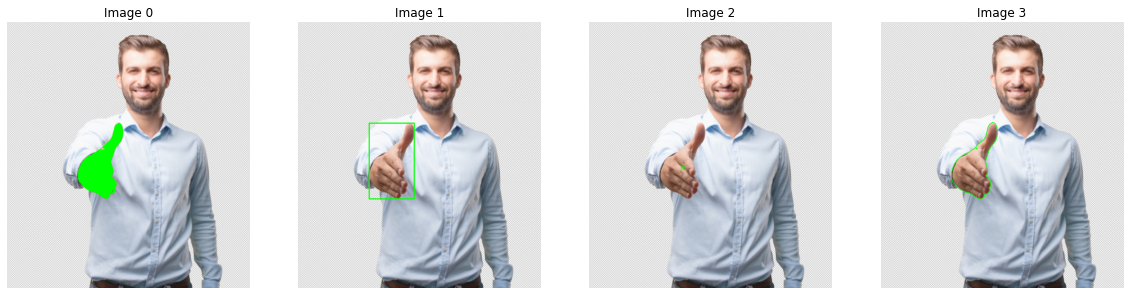

In [27]:
label_img = label(skinMask)
regions = regionprops(label_img, intensity_image= image_ycbcr[:,:,1], coordinates='rc')
mask_condition = skinMask * 0
for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel

    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity
    app_std = (imax - imin)/4

    minr, minc, maxr, maxc = props.bbox
    width = maxc - minc
    height = maxr - minr
    ratewh = width/height
    rateArea = area/ (width * height)
    
    condition = (area > 1000) and (area < 13000) and (ratewh < 1.5) and (rateArea > 0.3)
    if(condition):
        mask_condition = mask_condition + (imask).astype(int)
        print(area, ratewh, rateArea)
image_output1 = LabelObjectByMask(image_orig, mask_condition, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition, type = "Boundary", color = (0,255,0), thick = 2
)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

### Võng mạc

Selected Image :  
Index  47 
Name  Iris 03.jpg


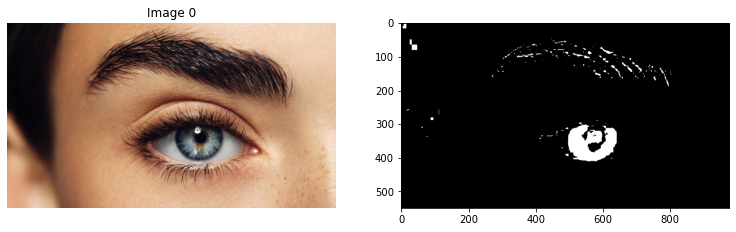

In [28]:
FileName = 'Iris 03.jpg'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)


lower = np.array([60, 0, 12], dtype = "uint8")
upper = np.array([130, 250, 250], dtype = "uint8")
skinMask = cv2.inRange(image_hsv, lower, upper)
ShowImage([image_orig,skinMask],1,3)

10452 1.3181818181818181 0.6552978056426332


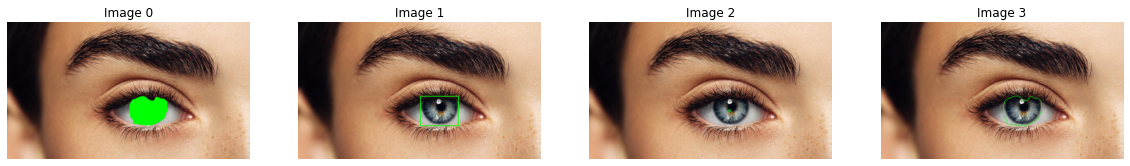

In [29]:
label_img = label(skinMask)
regions = regionprops(label_img, intensity_image= image_ycbcr[:,:,1])
mask_condition = skinMask * 0
for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel

    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity
    app_std = (imax - imin)/4

    minr, minc, maxr, maxc = props.bbox
    width = maxc - minc
    height = maxr - minr
    ratewh = width/height
    rateArea = area/ (width * height)
    
    condition = (area > 1000) and (area < 13000) and (ratewh < 1.5) and (rateArea > 0.3)
    if(condition):
        mask_condition = mask_condition + (imask).astype(int)
        print(area, ratewh, rateArea)
mask_condition = morphology(morphology(mask_condition,15),-11)
image_output1 = LabelObjectByMask(image_orig, mask_condition, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition, type = "Boundary", color = (0,255,0), thick = 2
)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

### Lá Phổi

Selected Image :  
Index  51 
Name  Lung 02.png


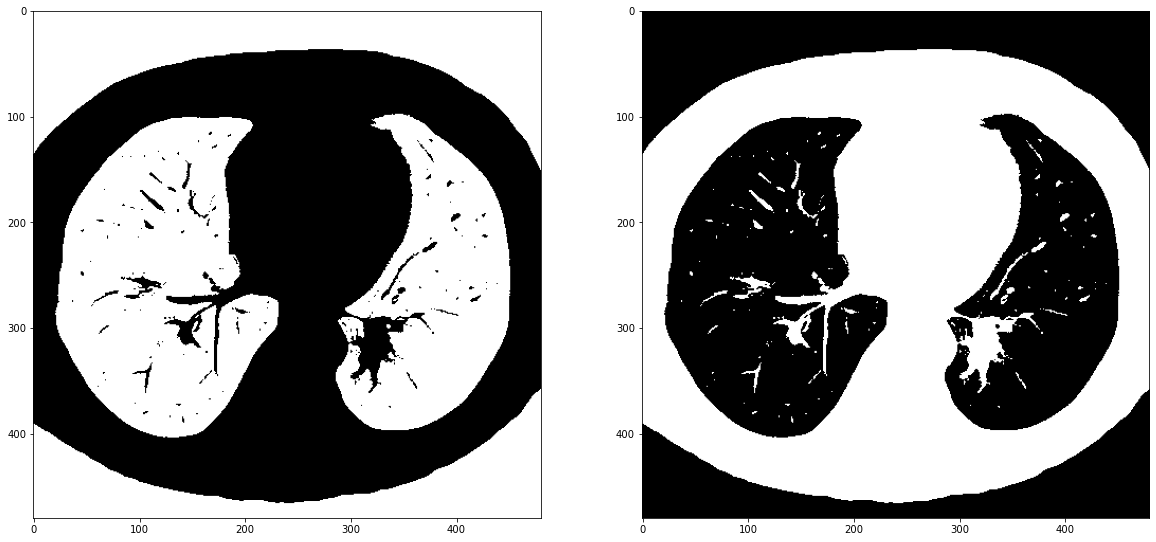

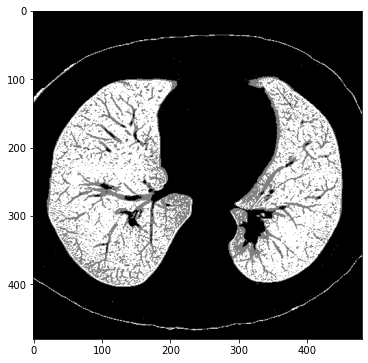

In [30]:
FileName = 'Lung 02.png'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)

image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 2)

mask_list = []
mask_abnormal = image_gray * 0
for idx in range(image_index.max() + 1):
    imask = image_index == idx
    otsu_thresh = SegmentationByOtsu(image_gray,imask)
    mask_small = -image_gray > otsu_thresh
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

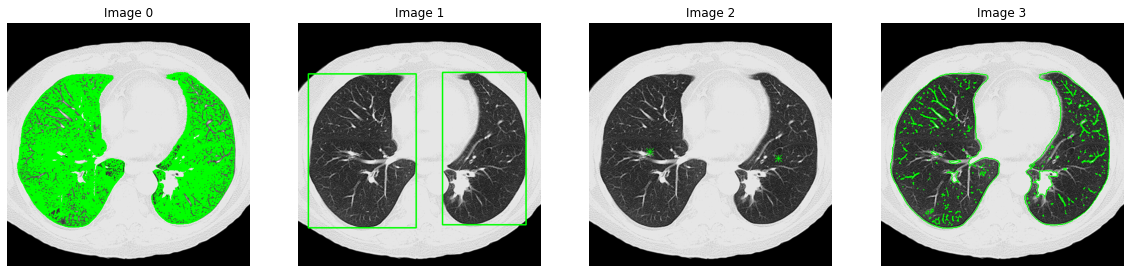

In [31]:
label_img = label(mask_abnormal)
regions = regionprops(label_img, intensity_image= image_gray)

mask_condition1 = mask_abnormal * 0

for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel

    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity

    condition1 = (area > 500)  and (imean > 30)
    if(condition1):
        mask_condition1 = mask_condition1 + (imask).astype(int)

image_output1 = LabelObjectByMask(image_orig, mask_condition1, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition1, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition1, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition1, type = "Boundary", color = (0,255,0), thick =2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

### Vết melanoma trên da

Selected Image :  
Index  55 
Name  Skin 01.jpg


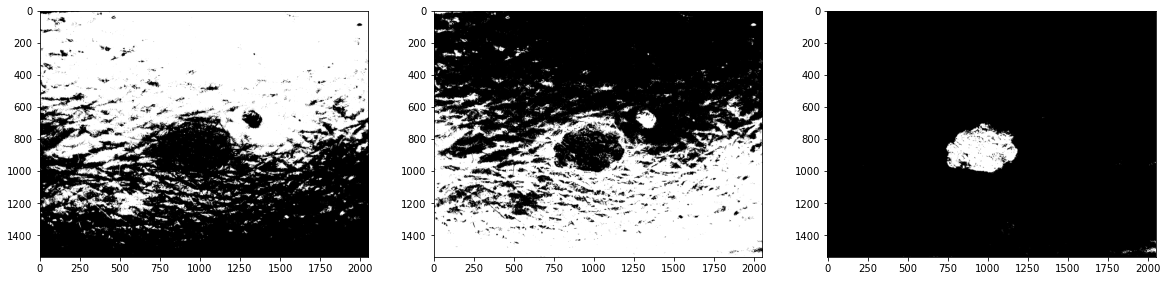

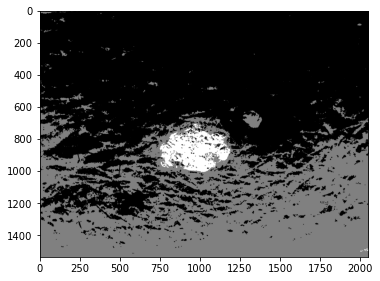

In [32]:
FileName = 'Skin 01.jpg'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)

image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 3)

mask_list = []
mask_abnormal = image_gray * 0
for idx in range(image_index.max() + 1):
    imask = image_index == idx
#     mask_small = SelectMaskByThreshArea(imask, minArea = 500, maxArea = 1000)
    mask_small=SegmentColorImageByMask(image_index, imask)
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small
mask_abnormal = morphology(mask_abnormal, -2)
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

area: 6999, imean: 138.18916988141163


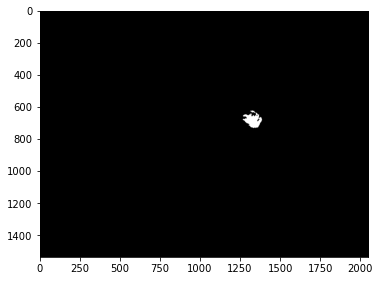

area: 66149, imean: 72.93523711620735


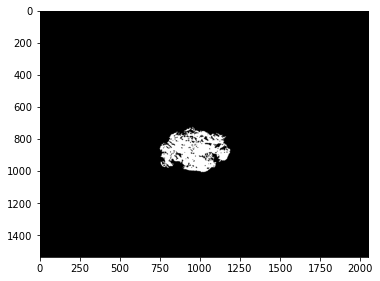

In [33]:

label_img = label(mask_abnormal)
regions = regionprops(label_img, intensity_image= image_gray)

mask_condition1 = mask_abnormal * 0

for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel

    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity


    condition1 = (((area >9000 and area < 100000)) ) and (imean > 10)
    condition2 = ((( area > 6500 and area < 10000)) ) and (imean > 10)
    
    if(condition1 or condition2):
        mask_condition1 = mask_condition1 + (imask).astype(int)
        print('area: {}, imean: {}'.format(area, imean))
        ShowImage([imask],1,3)
mask_condition1 = morphology(mask_condition1,2)


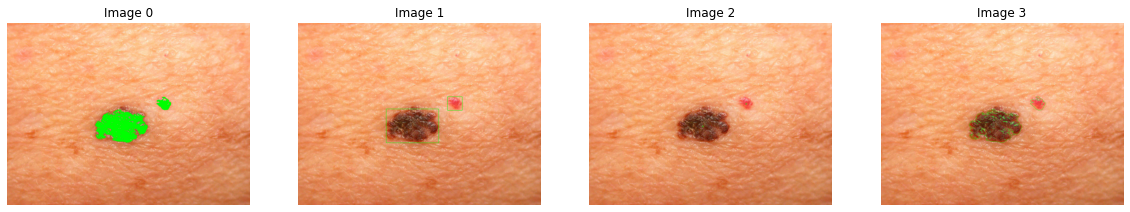

In [34]:
image_output1 = LabelObjectByMask(image_orig, mask_condition1, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition1, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition1, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition1, type = "Boundary", color = (0,255,0), thick =2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)